In [1]:
!pip install xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Set plotting styles
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [2]:
# --- 1. Load Data ---
# Define column names
column_names = [
    'unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
    'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12',
    'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18',
    'sensor_19', 'sensor_20', 'sensor_21'
]
# Load the training data for FD001
df = pd.read_csv('../data/raw/C-MAPSS/train_FD001.txt', sep=r'\s+', header=None, names=column_names)

In [3]:
# --- 2. Feature Engineering: Calculate RUL ---
max_cycles = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycles']
df = pd.merge(df, max_cycles, on='unit_number', how='left')
df['RUL'] = df['max_cycles'] - df['time_in_cycles']
df.drop(columns=['max_cycles'], inplace=True)

In [4]:
# --- 3. Drop Useless Columns ---
# These columns had zero or near-zero variance in our EDA
cols_to_drop = [
    'op_setting_3', 'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10',
    'sensor_16', 'sensor_18', 'sensor_19'
]
df_processed = df.drop(columns=cols_to_drop)

print("Shape of the dataframe after dropping useless columns:", df_processed.shape)
print("Remaining columns:", df_processed.columns.tolist())

Shape of the dataframe after dropping useless columns: (20631, 19)
Remaining columns: ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'RUL']


In [5]:
# --- 4. Feature Engineering: Rolling Window Features ---

# Define the window size
window_size = 5

# Get the list of sensor columns
sensor_cols = [col for col in df_processed.columns if col.startswith('sensor')]

# Calculate rolling mean and std for each sensor
for col in sensor_cols:
    # We calculate the rolling features per engine unit to avoid data leakage across units
    df_processed[f'{col}_rolling_mean'] = df_processed.groupby('unit_number')[col].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)
    df_processed[f'{col}_rolling_std'] = df_processed.groupby('unit_number')[col].rolling(window=window_size, min_periods=1).std().reset_index(level=0, drop=True)

# The rolling std for the first entry is NaN, so we fill it with 0
df_processed.fillna(0, inplace=True)

print("Shape of the dataframe after adding rolling features:", df_processed.shape)
print("\nExample of new features for Unit 1:")
df_processed[df_processed['unit_number'] == 1].head()

Shape of the dataframe after adding rolling features: (20631, 47)

Example of new features for Unit 1:


,unit_number,time_in_cycles,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,...,sensor_14_rolling_mean,sensor_14_rolling_std,sensor_15_rolling_mean,sensor_15_rolling_std,sensor_17_rolling_mean,sensor_17_rolling_std,sensor_20_rolling_mean,sensor_20_rolling_std,sensor_21_rolling_mean,sensor_21_rolling_std
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,...,8138.620000,0.000000,8.419500,0.000000,392.000000,0.000000,39.060000,0.000000,23.419000,0.000000
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,...,8135.055000,5.041671,8.425650,0.008697,392.000000,0.000000,39.030000,0.042426,23.421300,0.003253
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,...,8134.446667,3.717450,8.423033,0.007640,391.333333,1.154701,39.003333,0.055076,23.395600,0.044573
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,...,8134.292500,3.050906,8.409325,0.028117,391.500000,1.000000,38.972500,0.076322,23.390175,0.037977
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,...,8134.194000,2.651326,8.413340,0.025953,391.800000,1.095445,38.958000,0.073621,23.393020,0.033498


In [6]:
# --- 5. Cap RUL for a more focused regression problem ---
# Capping the RUL at 125 cycles
rul_cap = 125
df_processed['RUL'] = df_processed['RUL'].clip(upper=rul_cap)

In [7]:
# --- 6. Prepare Final Data for Modeling ---
# Define features (X) and target (y)
# We drop the identifiers and the original RUL target
y = df_processed['RUL']
X = df_processed.drop(columns=['unit_number', 'time_in_cycles', 'RUL'])

# Get the list of feature names for later use (e.g., with SHAP)
feature_names = X.columns.tolist()

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)
print("\nFirst 5 rows of the final feature set (X):")
X.head()

Features (X) shape: (20631, 44)
Target (y) shape: (20631,)

First 5 rows of the final feature set (X):


,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,...,sensor_14_rolling_mean,sensor_14_rolling_std,sensor_15_rolling_mean,sensor_15_rolling_std,sensor_17_rolling_mean,sensor_17_rolling_std,sensor_20_rolling_mean,sensor_20_rolling_std,sensor_21_rolling_mean,sensor_21_rolling_std
0,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,...,8138.620000,0.000000,8.419500,0.000000,392.000000,0.000000,39.060000,0.000000,23.419000,0.000000
1,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,...,8135.055000,5.041671,8.425650,0.008697,392.000000,0.000000,39.030000,0.042426,23.421300,0.003253
2,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,...,8134.446667,3.717450,8.423033,0.007640,391.333333,1.154701,39.003333,0.055076,23.395600,0.044573
3,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,...,8134.292500,3.050906,8.409325,0.028117,391.500000,1.000000,38.972500,0.076322,23.390175,0.037977
4,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,...,8134.194000,2.651326,8.413340,0.025953,391.800000,1.095445,38.958000,0.073621,23.393020,0.033498


In [8]:
# --- 7. Split the Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# --- 8. Scale the Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (16504, 44)
Test set shape: (4127, 44)


In [10]:
! pip install --upgrade xgboost

In [11]:
# --- 9. Train the XGBoost Model (XGBoost 3.0+ Syntax) ---
print("\nTraining XGBoost model...")
# Initialize the XGBoost Regressor with early stopping parameters included here
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    # --- Correct parameters for XGBoost 3.0+ ---
    early_stopping_rounds=50
)

# Train the model. The eval_set is now the only extra parameter in .fit()
xgb_reg.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)
print("Model training complete.")


Training XGBoost model...
Model training complete.


In [12]:
# --- 10. Evaluate the Model ---
print("\nEvaluating model performance...")
# Predictions are now made using the best iteration
y_pred = xgb_reg.predict(X_test_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Evaluating model performance...
Root Mean Squared Error (RMSE): 15.86
R-squared (R²): 0.85


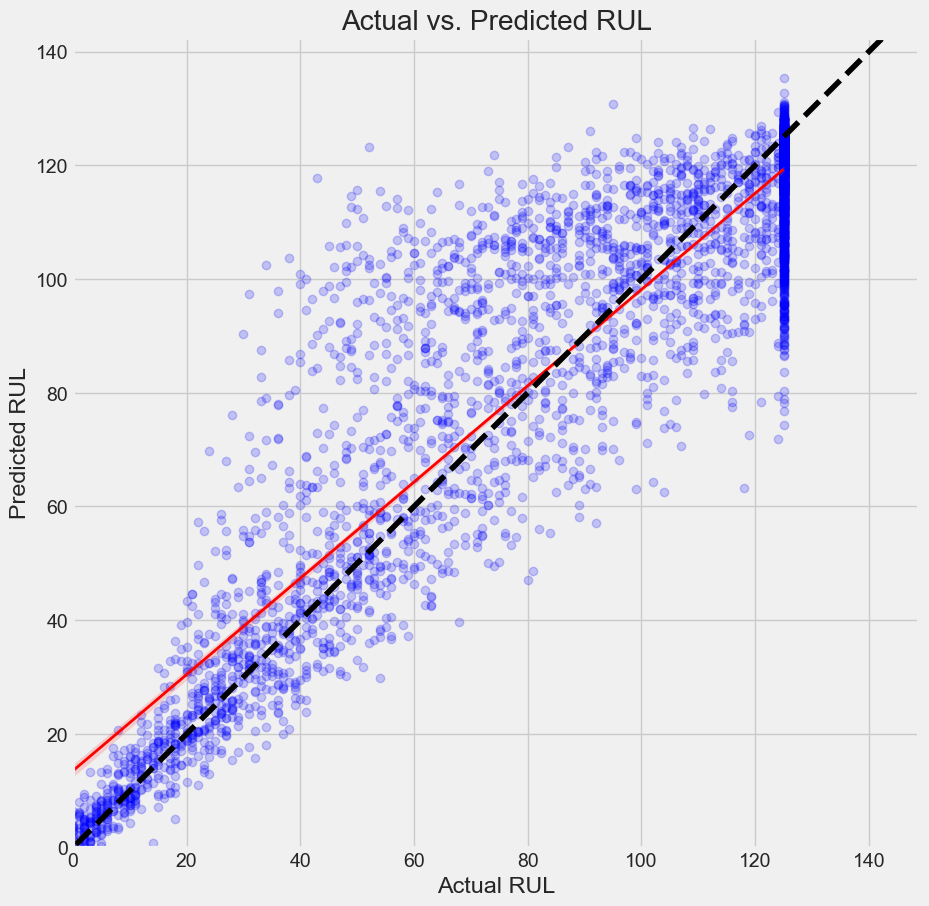

In [13]:
# --- 11. Visualize Predictions vs. Actuals ---
plt.figure(figsize=(10, 10))
sns.regplot(x=y_test, y=y_pred,
            scatter_kws={'alpha':0.2, 'color':'blue'},
            line_kws={'color':'red', 'linewidth':2})
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 500], [-100, 500], c='black', linestyle='--')
plt.show()

C:\Users\MY\AppData\Local\Temp\ipykernel_13400\101523115.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='features', data=feature_importance_df, palette='viridis')


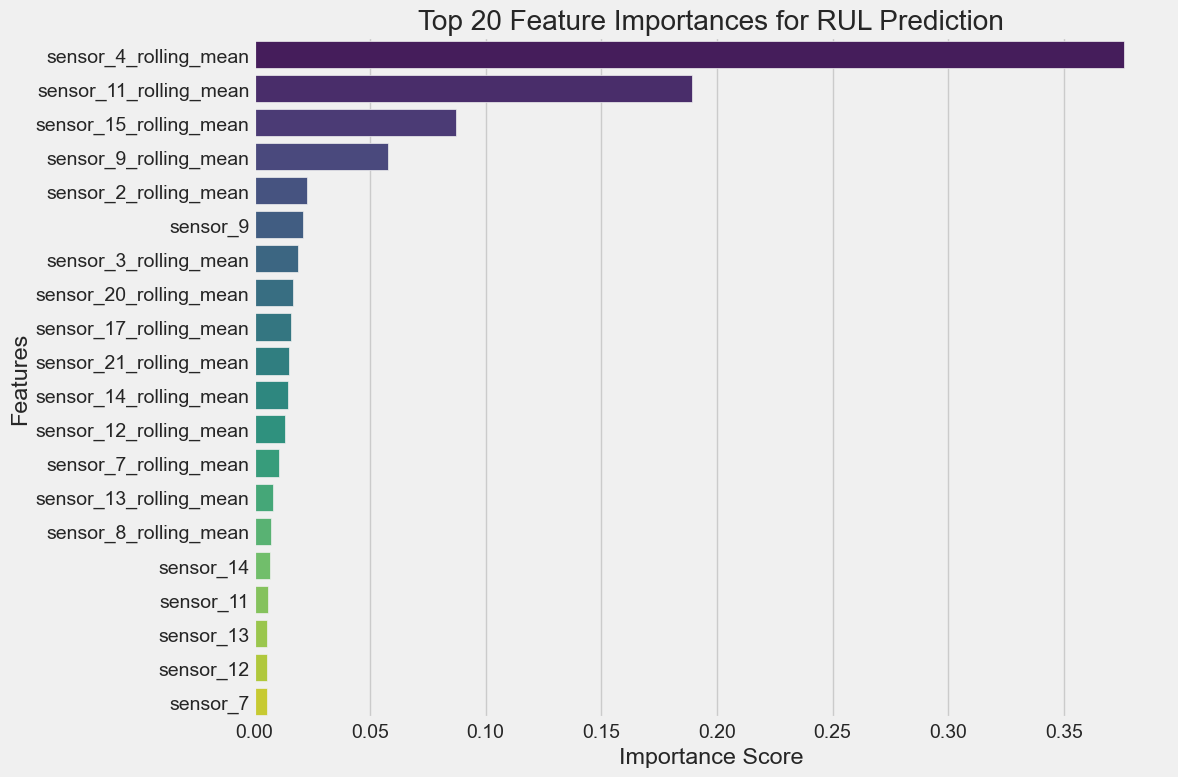

In [14]:
# --- 12. Plot Feature Importance (Improved Version) ---

# Get the feature importances from the trained model
importances = xgb_reg.feature_importances_
# Create a pandas DataFrame for easier plotting
feature_importance_df = pd.DataFrame({
    'features': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(20) # Get top 20

# Plot using Seaborn for better control and readability
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='features', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Feature Importances for RUL Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout() # Adjust layout to make sure labels fit
plt.show()

In [15]:
# --- 13. Save the Final Model and Scaler ---

# Define the directory to save the model artifacts
model_dir = '../ml_models/rul'
os.makedirs(model_dir, exist_ok=True) # Create the directory if it doesn't exist

# Define file paths
model_path = os.path.join(model_dir, 'rul_predictor.joblib')
scaler_path = os.path.join(model_dir, 'rul_scaler.pkl')

# Save the trained XGBoost model
joblib.dump(xgb_reg, model_path)
print(f"Model saved to: {model_path}")

# Save the fitted StandardScaler
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

Model saved to: ../ml_models/rul\rul_predictor.joblib
Scaler saved to: ../ml_models/rul\rul_scaler.pkl
